In [175]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from collections import defaultdict
import numpy as np
import pandas as pd
import unicodedata
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag, bigrams
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer
import nltk.collocations as collocations
from nltk.util import ngrams
import pickle
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, precision_score, recall_score,  confusion_matrix, ConfusionMatrixDisplay,balanced_accuracy_score
from sklearn.metrics import precision_recall_fscore_support, f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, RocCurveDisplay, log_loss
from sklearn.ensemble import VotingClassifier, BaggingClassifier
from sklearn.dummy import DummyClassifier 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate, KFold, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras import datasets, layers, models, callbacks
from kerastuner.tuners import RandomSearch
from keras import backend as K
from imblearn.over_sampling import RandomOverSampler

nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danayt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/danayt/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package tagsets to /Users/danayt/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/danayt/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/danayt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [176]:
# !pip install wordcloud

In [177]:
import sklearn
sklearn.__version__

'1.3.1'

In [178]:
# !pip install keras-tuner

In [179]:
data = pd.read_csv("./raw_data/judge-1377884607_tweet_product_company.csv", encoding='unicode_escape')

In [180]:
# dopping null column from tweet_text column since it's only one and has no information for our analysis
data.tweet_text.isna().sum()
data.dropna(subset=['tweet_text'], inplace=True)

In [181]:
# looking at our .describe, there seems to be some duplicates in our data and we'll go ahead and keep unique inputs only
data.drop_duplicates(subset=['tweet_text'], inplace=True)

In [182]:
# Creating a cleaned emotion_in tweet_is_directed_at column
data.rename(columns={'emotion_in_tweet_is_directed_at': 'brand'}, inplace=True)
data.rename(columns={'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'}, inplace=True)

In [183]:
keywords = ["Apple", "Google", "iPad", "iPhone", "Android", "goog"]

for keyword in keywords:
    data[keyword] = data['tweet_text'].str.extract(f'({keyword})', flags=re.IGNORECASE)

data['product'] = data[['Apple', 'iPhone', 'iPad', 'Google', 'Android']].apply(lambda x: 'Apple' if x[['Apple', 'iPhone', 'iPad']].any() 
                                                                                else 'Google' if x[['Google', 'Android']].any() 
                                                                                else None, axis=1)

In [184]:
data['product'].value_counts()

product
Apple     5517
Google    2764
Name: count, dtype: int64

In [185]:
# Since we've classified our product column, we'll drop nulls as we're interested with apple and google products
data['product'].isna().sum()

784

In [186]:
#Dropped to focus on tweets where google and apple where mentioned
data.dropna(subset=['product'], inplace=True)

In [187]:
data['sentiment'].replace("I can't tell" , "Neutral emotion", inplace=True)
data['sentiment'].replace("No emotion toward brand or product" , "Neutral emotion", inplace=True)
data['sentiment'].replace("No emotion toward brand or product" , "Neutral emotion", inplace=True)

In [188]:
target_to_replace = {'Positive emotion':2, 'Neutral emotion':1,
                   'Negative emotion':0}

data['sentiment']  = data['sentiment'].replace(target_to_replace)

In [189]:
data['sentiment'].value_counts(normalize=True)

sentiment
1    0.577587
2    0.353822
0    0.068591
Name: proportion, dtype: float64

In [190]:
data['product'].value_counts()

product
Apple     5517
Google    2764
Name: count, dtype: int64

In [191]:
data['product'] = data['product'].astype(str)

In [192]:
sw = stopwords.words('english')
sw.extend(["apple", "google", "ipad", "iphone", "android", "sxsw", "link", "mention", "sxwsi", "hmmm","rt" "sxswu", "goog", "iusxsw",
           "etc", "via", "today", "hmmmm"])

In [193]:
# Custom tokenizer
def doc_preparer(doc, stop_words=sw):

    #lemmatized, parsed for stopwords, made lowercase,and stripped of punctuation and numbers.
    doc = unicodedata.normalize('NFKD', doc).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # Remove URLs
    doc = re.sub(r'http\S+|www\S+|https\S+', '', doc, flags=re.MULTILINE)
    # Remove mentions and hashtags
    doc = re.sub(r'\@\w+|\#','', doc)
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    doc = [word for word in doc if len(word) > 2]  # Remove tokens with length <= 1
    # print(doc)
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)
 # Translate nltk POS to wordnet tags
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [194]:
# Extracting important features from our data 
corpse = data.tweet_text
target = data.sentiment
product = data.product

In [195]:
token_text = [doc_preparer(doc,sw) for doc in corpse]

In [196]:
# Convert the 'product' column to strings
data['product'] = data['product'].astype(str)

# Concatenate the "corpse" and "product" columns
data['text_with_product'] = [text + ' ' + product for text, product in zip(token_text, data['product'])]

In [197]:
data

,tweet_text,brand,sentiment,Apple,Google,iPad,iPhone,Android,goog,product,text_with_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,0,NaN,NaN,NaN,iPhone,NaN,NaN,Apple,hr tweet rise austin dead need upgrade plugin ...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,2,NaN,NaN,iPad,iPhone,NaN,NaN,Apple,know awesome app likely appreciate design also...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,2,NaN,NaN,iPad,NaN,NaN,NaN,Apple,wait also sale Apple
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,0,NaN,NaN,NaN,iPhone,NaN,NaN,Apple,hope year festival crashy year app Apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,2,NaN,Google,NaN,NaN,NaN,Goog,Google,great stuff fri marissa mayer tim reilly tech ...
...,...,...,...,...,...,...,...,...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,2,NaN,NaN,Ipad,NaN,NaN,NaN,Apple,everywhere Apple
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,1,NaN,google,NaN,NaN,NaN,goog,Google,wave buzz interrupt regularly schedule geek pr...
9090,"Google's Zeiger, a physician never reported po...",NaN,1,NaN,Google,NaN,NaN,NaN,Goog,Google,zeiger physician never report potential yet fd...
9091,Some Verizon iPhone customers complained their...,NaN,1,NaN,NaN,NaN,iPhone,NaN,NaN,Apple,verizon customer complain time fell back hour ...


In [241]:
data.groupby(['product', 'sentiment']).count()

tweet_text  brand  Apple  Google  iPad  iPhone  Android  \
product sentiment                                                            
Apple   0                 419    389    116       1   189     161        8   
        1                2973     72   1168      27  1489     862      144   
        2                2125   1939    847      18  1198     546       54   
Google  0                 149    129      0     134     0       0       16   
        1                1810     28      0    1614     0       0      210   
        2                 805    698      0     668     0       0      142   

                   goog  text_with_product  tokenized_text  
product sentiment                                           
Apple   0             1                419             419  
        1            28               2973            2973  
        2            19               2125            2125  
Google  0           134                149             149  
        1          1614               1810            1810  
        2           668                805             805

In [240]:
apple_sentiment = data['product'].groupby(data['sentiment'])

# Exploratory Data Analysis 

In [198]:
# Tokenize text by words for each row in the 'processed_text' column
data['tokenized_text'] = data['text_with_product'].apply(lambda x: word_tokenize(x))

In [199]:
# Check the number of words by summing the lengths of the tokenized lists
total_words = data['tokenized_text'].apply(len).sum()
total_words

74661

In [200]:
# Combine all the tokenized words into a single list
all_words = [word for tokenized_text in data['tokenized_text'] for word in tokenized_text]

# Calculate the frequency distribution
freq_dist = FreqDist(all_words)

# Print the top ten words
print(freq_dist.most_common(20))

[('Apple', 5517), ('Google', 2764), ('quot', 1583), ('store', 1507), ('new', 1047), ('austin', 901), ('app', 774), ('launch', 762), ('amp', 731), ('circle', 664), ('get', 656), ('social', 627), ('pop', 607), ('open', 503), ('network', 458), ('line', 456), ('call', 383), ('party', 353), ('mobile', 341), ('come', 317)]


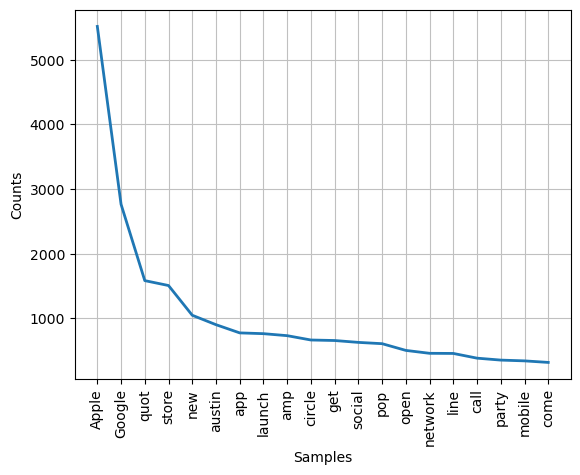

In [201]:

#Plot the 10 most common words
freq_dist.plot(20)
plt.show();

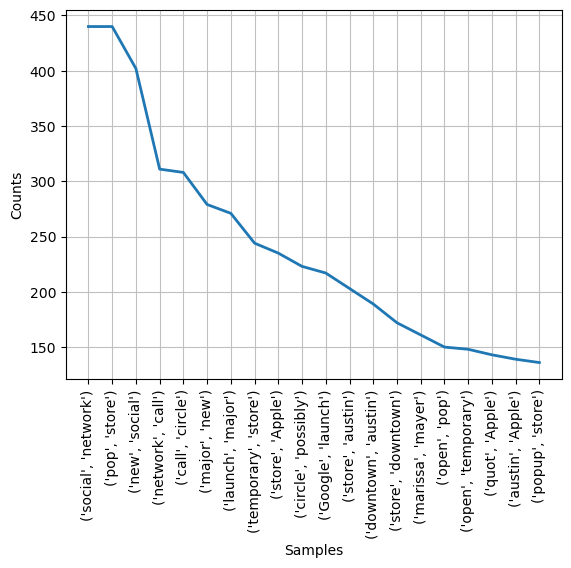

<Axes: xlabel='Samples', ylabel='Counts'>

In [202]:
bigrams = nltk.bigrams(all_words)
tokenized_bigrams = nltk.FreqDist(bigrams)
tokenized_bigrams.most_common(20)
tokenized_bigrams.plot(20)

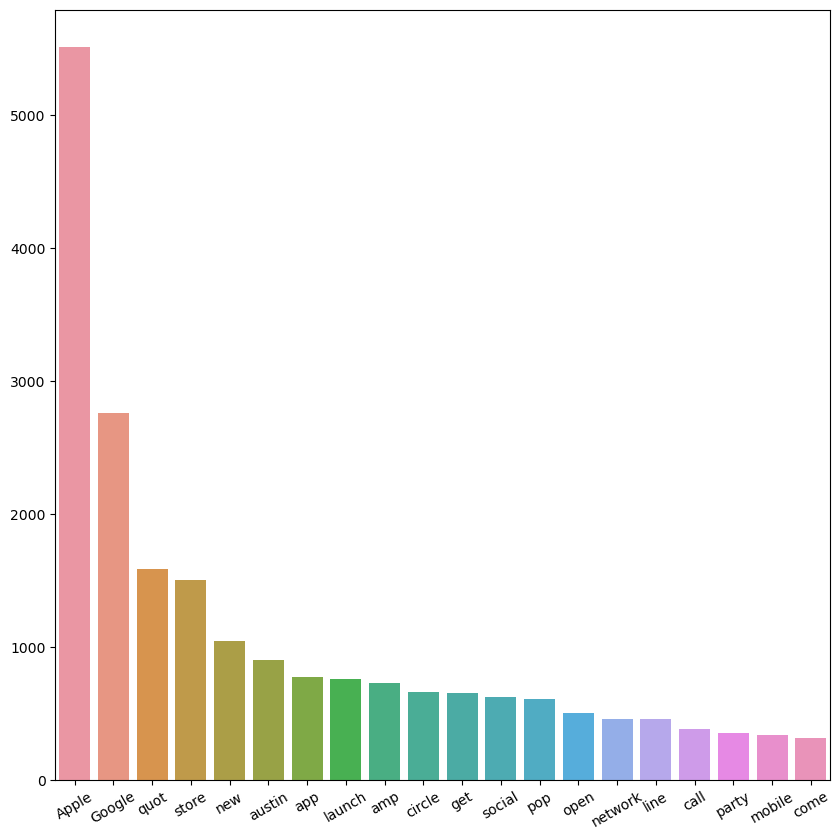

In [203]:
# Creating FreqDist for whole BoW, keeping the 20 most common tokens
all_fdist = FreqDist(all_words).most_common(20)

# Conversion to Pandas series via Python Dictionary for easier plotting
all_fdist = pd.Series(dict(all_fdist))

# Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(10,10))

# Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax)
plt.xticks(rotation=30);

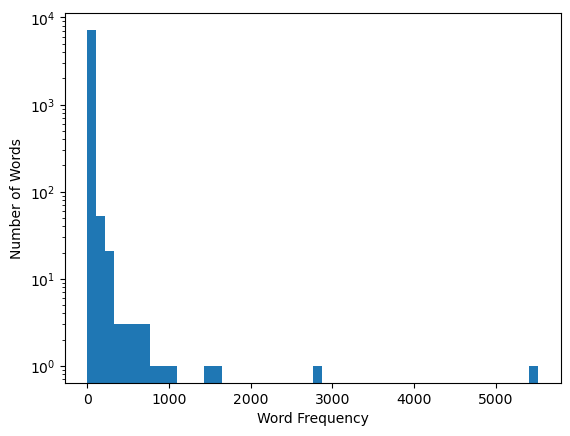

In [204]:
# Vectorize the text
vectorizer = CountVectorizer()
corpse = ()
X = vectorizer.fit_transform(data['text_with_product'])

# Sum the word frequencies
word_freq = X.sum(axis=0)

# Convert to a numpy array and flatten
word_freq = word_freq.A1

# Plot the distribution
plt.hist(word_freq, bins=50, log=True)
plt.xlabel('Word Frequency')
plt.ylabel('Number of Words')
plt.show();

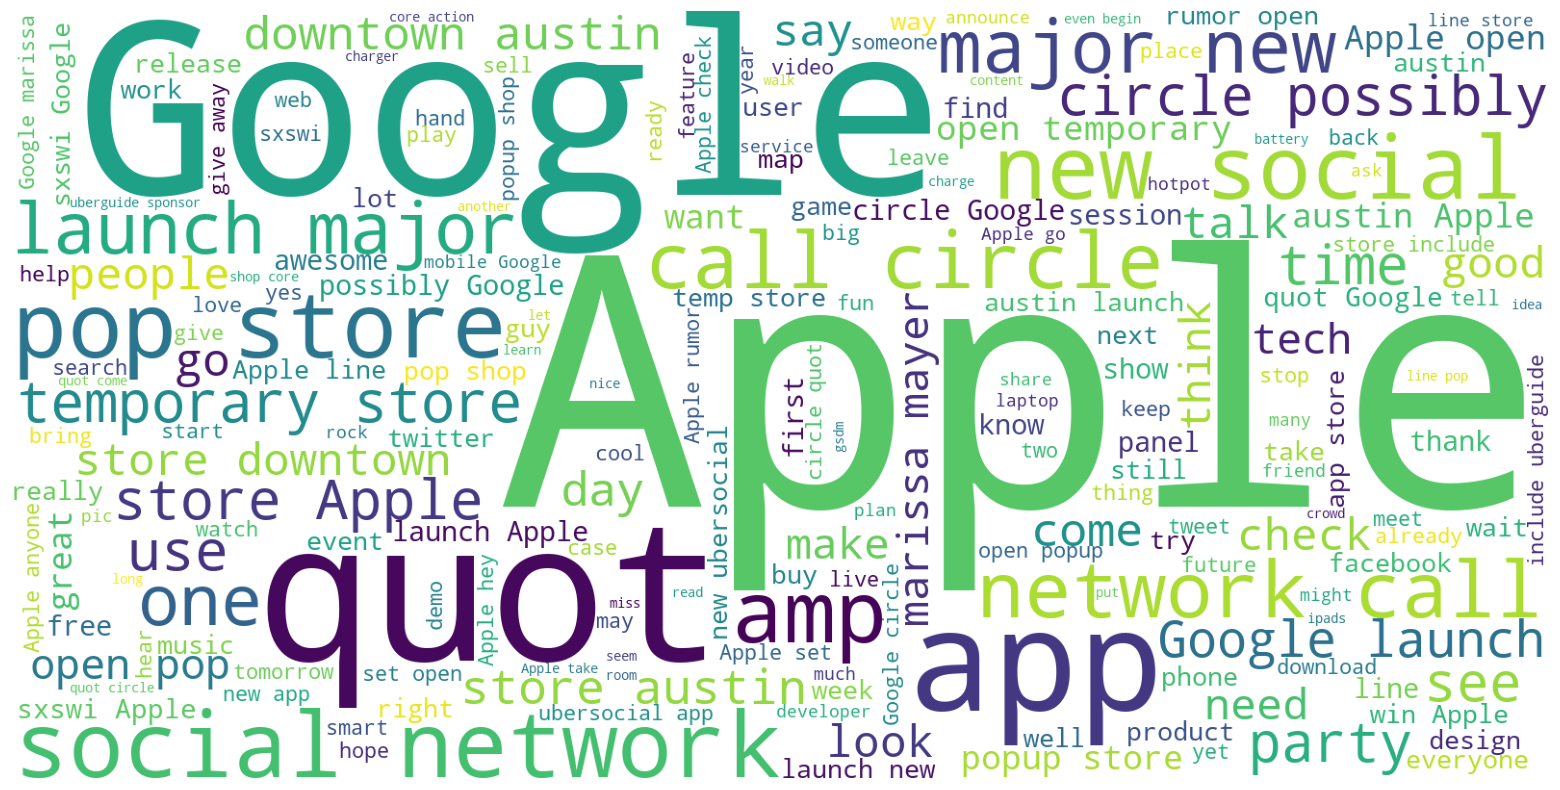

<Figure size 640x480 with 0 Axes>

In [205]:
#Convert word list to a single string
words_string = " ".join(all_words)

#generating the wordcloud
wordcloud = WordCloud(background_color="white", width=1600, height=800).generate(words_string)

#plot the wordcloud
plt.figure(figsize = (20, 10))
plt.imshow(wordcloud)

#to remove the axis value
plt.axis("off")
plt.show();

plt.savefig("cloudword.png")

# Train test split and evaluation metrics

In [ ]:
class EvaluationMetrics:
                           
    def __init__(self, pipe, X_train, X_test, y_train, y_test, X_val, y_val):
        self.pipe = pipe
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.X_val = X_val
        self.y_val = y_val
        self.model_df = pd.DataFrame(columns=['Model', 'Train Accuracy', 'Train Recall', 'Train Precision', 'Train F1-Score',
                                              'Test Accuracy', 'Test Recall', 'Test Precision', 'Test F1-Score',
                                              'Validation Accuracy', 'Validation Recall', 'Validation Precision', 'Validation F1-Score'])

    def print_scores(self):
        # Training set predictions
        y_train_pred = self.pipe.predict(self.X_train)
        train_results_dict = {'accuracy': accuracy_score(self.y_train, y_train_pred),
                              'recall': recall_score(self.y_train, y_train_pred, average='weighted'),
                              'precision': precision_score(self.y_train, y_train_pred, average='weighted'),
                              'f1_score': f1_score(self.y_train, y_train_pred, average='weighted')}

        # Test set predictions
        y_test_pred = self.pipe.predict(self.X_test)
        test_results_dict = {'accuracy': accuracy_score(self.y_test, y_test_pred),
                             'recall': recall_score(self.y_test, y_test_pred, average='weighted'),
                             'precision': precision_score(self.y_test, y_test_pred, average='weighted'),
                             'f1_score': f1_score(self.y_test, y_test_pred, average='weighted')}

        # Validation set predictions
        y_val_pred = self.pipe.predict(self.X_val)
        val_results_dict = {'accuracy': accuracy_score(self.y_val, y_val_pred),
                            'recall': recall_score(self.y_val, y_val_pred, average='weighted'),
                            'precision': precision_score(self.y_val, y_val_pred, average='weighted'),
                            'f1_score': f1_score(self.y_val, y_val_pred, average='weighted')}

        return train_results_dict, test_results_dict, val_results_dict
        
    def cross_validation(self, cv=5):
        scores = cross_val_score(self.pipe, self.X_train, self.y_train, cv=cv, scoring='accuracy')
        return np.mean(scores), np.std(scores)
        
    # Plots ROC curve for all classes 
    def plot_roc_curve_ovr(self):
        # Calculate FPR and TPR for each class (One-vs-Rest)
        y_test_pred_proba = self.pipe.predict_proba(self.X_test)
        n_classes = y_test_pred_proba.shape[1]
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(self.y_test, y_test_pred_proba[:, i], pos_label=i)

        # Plot ROC curve for each class (One-vs-Rest)
        plt.figure()
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], label=f'Class {i}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - One-vs-Rest')
        plt.legend(loc="lower right")
        plt.show()
        
    # Plots confusion matrix
    def plot_confusion_matrix(self, y_train, y_train_pred):
        cm = confusion_matrix(y_train, y_train_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()
        
    def record_results(self, model_name, train_results, test_results, val_results):
        self.model_df = self.model_df.append({'Model': model_name,
                                              'Train Accuracy': train_results['accuracy'],
                                              'Train Recall': train_results['recall'],
                                              'Train Precision': train_results['precision'],
                                              'Train F1-Score': train_results['f1_score'],
                                              'Test Accuracy': test_results['accuracy'],
                                              'Test Recall': test_results['recall'],
                                              'Test Precision': test_results['precision'],
                                              'Test F1-Score': test_results['f1_score'],
                                              'Validation Accuracy': val_results['accuracy'],
                                              'Validation Recall': val_results['recall'],
                                              'Validation Precision': val_results['precision'],
                                              'Validation F1-Score': val_results['f1_score']}, ignore_index=True)

In [206]:
# Assign the concatenated text to X
X = data['text_with_product']

# Assign the target labels to y
y = data['sentiment']

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.33)

In [209]:
class EvaluationMetrics:
                           
    def __init__(self, pipe, X_train, X_test, y_train, y_test):
        self.pipe = pipe
        self.X_train = X_train
        self.X_test= X_test
        self.y_train = y_train
        self.y_test = y_test

    def print_scores(self):
        # Training set predictions
        y_train_pred = self.pipe.predict(self.X_train)
        train_results_dict = {'accuracy': accuracy_score(self.y_train, y_train_pred),
                              'recall': recall_score(self.y_train, y_train_pred, average='weighted'),
                              'precision': precision_score(self.y_train, y_train_pred, average='weighted'),
                              'f1_score': f1_score(self.y_train, y_train_pred, average='weighted')}

        
        y_test_pred = self.pipe.predict(X_test)
        test_results_dict = {'accuracy': accuracy_score(y_test, y_test_pred),
                         'recall': recall_score(y_test, y_test_pred, average='weighted'),
                         'precision': precision_score(y_test, y_test_pred, average='weighted'),
                         'f1_score': f1_score(y_test, y_test_pred, average='weighted')}

        return train_results_dict, test_results_dict
        
    def cross_validation(self, cv=5):
        scores = cross_val_score(self.pipe, self.X_train, self.y_train, cv=cv, scoring='accuracy')
        return np.mean(scores), np.std(scores)
        
     # Plots roc curve for all classes 
    def plot_roc_curve_ovr(self):
        # Calculate FPR and TPR for each class (One-vs-Rest)
        y_test_pred_proba = self.pipe.predict_proba(self.X_test)
        n_classes = y_test_pred_proba.shape[1]
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(self.y_test, y_test_pred_proba[:, i], pos_label=i)

        # Plot ROC curve for each class (One-vs-Rest)
        plt.figure()
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], label=f'Class {i}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - One-vs-Rest')
        plt.legend(loc="lower right")
        plt.show()
    # Plots confussion matrix
    def plot_confusion_matrix(self, y_train, y_train_pred):
        cm = confusion_matrix(y_train, y_train_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()

# Dummy Model

In [210]:
dummy = Pipeline([
    ('vect', CountVectorizer(min_df=0.05, max_df=0.95)),
    ('dummy', DummyClassifier(random_state=42, ))
])

# Fit the pipeline to the training data
dummy.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(max_df=0.95, min_df=0.05)),
                ('dummy', DummyClassifier(random_state=42))])

Training Set Metrics:
accuracy: 0.5717375630857967
recall: 0.5717375630857967
precision: 0.3268838410432854
f1_score: 0.4159521903917769

Test set results:
accuracy: 0.5894621295279913
recall: 0.5894621295279913
precision: 0.3474656021476743
f1_score: 0.43721155187366206

cv set results:
Mean Accuracy: 0.5717375445779413
Standard Deviation of Accuracy: 0.00033162264040441933


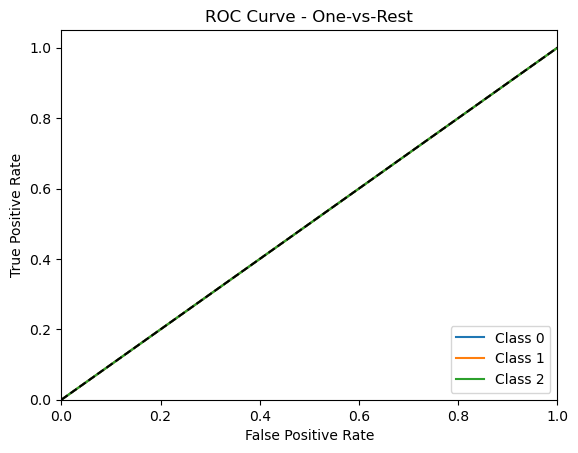

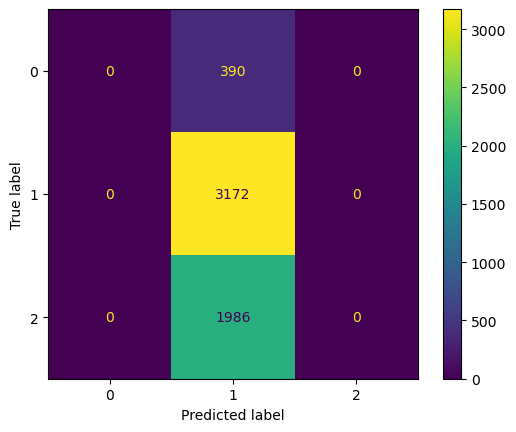

In [211]:
dummy_metrics = EvaluationMetrics(dummy, X_train, X_test, y_train, y_test)

# Print the evaluation metrics
train_results, test_results = dummy_metrics.print_scores()
print("Training Set Metrics:")
for metric, score in train_results.items():
    print(f"{metric}: {score}")   
print("\nTest set results:")
for metric, value in test_results.items():
    print(f"{metric}: {value}")
print("\ncv set results:")
mean_accuracy, std_accuracy = dummy_metrics.cross_validation(cv=5)
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)

# Plot the ROC curve
dummy_metrics.plot_roc_curve_ovr()

#Plot MAtrix Confusion
y_train_pred = dummy_metrics.pipe.predict(X_train)
dummy_metrics.plot_confusion_matrix(y_train, y_train_pred)

In [212]:
results

,model,vectorizer,val_score,train_acc,test_acc,train_recall,test_recall,train_precision,test_precision,train_f1_score,test_f1_score,train_f1_score,train_logloss,test_logloss,info


In [213]:
recorder = ModelResultsRecorder()

In [214]:
# results = pd.DataFrame(columns=["model","vectorizer", "val_score", "train_acc", "test_acc","train_recall", "test_recall", 
#                                 "train_precision", "test_precision","train_f1_score","test_f1_score","train_f1_score",
#                                 "train_logloss","test_logloss",'info'])

# First model, baseline performance to record to our results table
# Edit to include the definitions included in results df columns
# This to used as a recorder for rest of models
# results_1 = pd.DataFrame({       
#      "model":['Dummyreggressor'],
#     "vectorizer":['Countvector'],
#     "val_score": [0.57],
#     "train_acc" :[0.33],
#     "test_acc": [0.58],
#     "train_recall":[0.57],
#     "test_recall": [0.58],
#     "train_precision":[0.33],
#     "test_precision": [0.34],
#     "train_f1_score":[0.42],
#     "test_f1_score":[0.43],
#     'info' : ['baseline']
# })
# results = pd.concat([results, results_1], ignore_index =True)

# Logistic Regression using CountVectorizer

In [215]:
# Best Parameters:  {'logreg__C': 0.1, 'logreg__class_weight': 'balanced', 'logreg__max_iter': 250, 'logreg__multi_class': 'ovr', 
#                    'logreg__penalty': 'l2', 'logreg__solver': 'liblinear', 
#                    'vect__analyzer': 'word', 'vect__max_df': 0.75, 'vect__max_features': 500, 'vect__min_df': 0.01, 'vect__ngram_range': (1, 1)}
# fsm = Pipeline([
#     ('vect', CountVectorizer(analyzer=word, min_df=0.05, max_df=0.75,)),
#     ('logreg', LogisticRegression(random_state=42, ))
# ])

# # Fit the pipeline to the training data
# fsm.fit(X_train, y_train)

Training Set Metrics:
accuracy: 0.5807498197548666
recall: 0.5807498197548666
precision: 0.5195136556460274
f1_score: 0.48686923691622375

Test set results:
accuracy: 0.5883644346871569
recall: 0.5883644346871569
precision: 0.5142464030928691
f1_score: 0.5011131100244397

cv set results:
Mean Accuracy: 0.5758836383723669
Standard Deviation of Accuracy: 0.00481324748952238


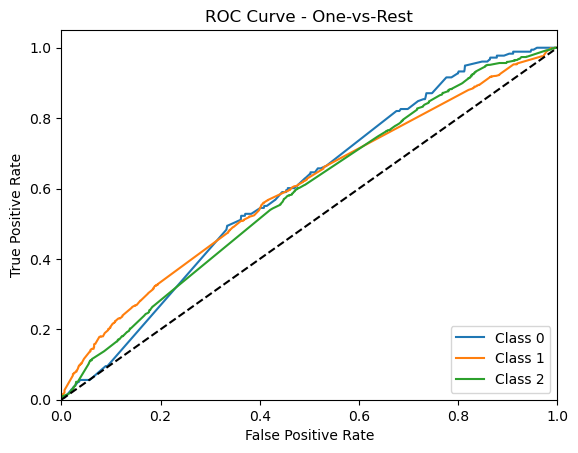

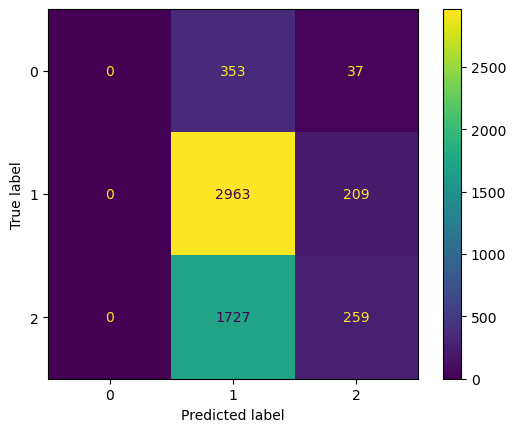

In [216]:
fsm_metrics = EvaluationMetrics(fsm, X_train, X_test, y_train, y_test)

# Print the evaluation metrics
train_results, test_results = fsm_metrics.print_scores()
print("Training Set Metrics:")
for metric, score in train_results.items():
    print(f"{metric}: {score}")   
print("\nTest set results:")
for metric, value in test_results.items():
    print(f"{metric}: {value}")
print("\ncv set results:")
mean_accuracy, std_accuracy = fsm_metrics.cross_validation(cv=5)
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)
# Plot the ROC curve
fsm_metrics.plot_roc_curve_ovr()

#Plot MAtrix Confusion
y_train_pred = fsm_metrics.pipe.predict(X_train)
fsm_metrics.plot_confusion_matrix(y_train, y_train_pred)

In [217]:
#results

# Logistic regression with Tf-idf vectorizer

In [218]:
lrpipe = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1, 2))),
    ('logreg', LogisticRegression(random_state=42))
])

# Fit the pipeline to the training data
lrpipe.fit(X_train, y_train)

Pipeline(steps=[('vect', TfidfVectorizer(ngram_range=(1, 2))),
                ('logreg', LogisticRegression(random_state=42))])

Training Set Metrics:
accuracy: 0.8592285508291276
recall: 0.8592285508291276
precision: 0.8735465358834534
f1_score: 0.8390694098540815

Test set results:
accuracy: 0.6845956824002927
recall: 0.6845956824002927
precision: 0.6766414297182466
f1_score: 0.6572576529427773

cv set results:
Mean Accuracy: 0.6559146703060139
Standard Deviation of Accuracy: 0.007427137179174143


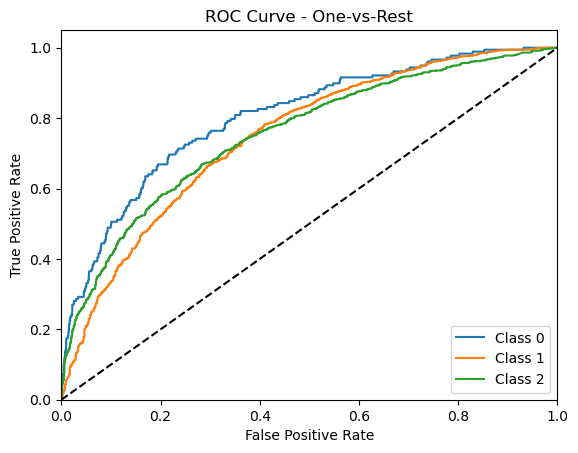

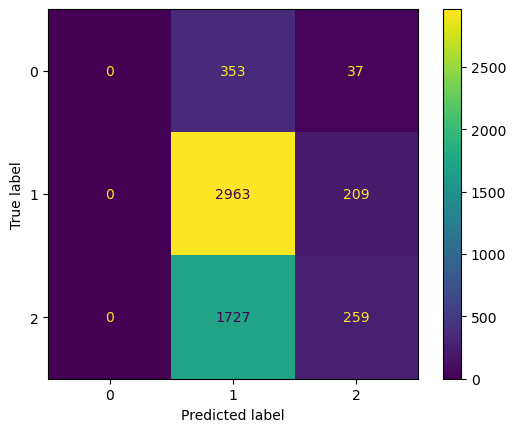

In [219]:
lrpipe_metrics = EvaluationMetrics(lrpipe, X_train, X_test, y_train, y_test)

# Print the evaluation metrics
train_results, test_results = lrpipe_metrics.print_scores()
print("Training Set Metrics:")
for metric, score in train_results.items():
    print(f"{metric}: {score}")   
print("\nTest set results:")
for metric, value in test_results.items():
    print(f"{metric}: {value}")
print("\ncv set results:")
mean_accuracy, std_accuracy = lrpipe_metrics.cross_validation(cv=5)
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)
# Plot the ROC curve
lrpipe_metrics.plot_roc_curve_ovr()

#Plot MAtrix Confusion
y_t_pred = lrpipe_metrics.pipe.predict(X_train)
lrpipe_metrics.plot_confusion_matrix(y_train, y_train_pred)

In [220]:
#results

# Synthethic Balancing with Tf-idf and Logistic Regression

In [221]:
# Best Parameters:  {'logreg__C': 0.1, 'logreg__class_weight': 'balanced', 'logreg__max_iter': 250, 'logreg__multi_class': 'ovr', 
#                    'logreg__penalty': 'l2', 'logreg__solver': 'liblinear', 
#                    'vect__analyzer': 'word', 'vect__max_df': 0.75, 'vect__max_features': 500, 'vect__min_df': 0.01, 'vect__ngram_range': (1, 1)}

In [226]:
from imblearn.pipeline import make_pipeline

# Create an instance of RandomOverSampler
oversampler = RandomOverSampler()

# Define the pipeline
lrpipe_os = make_pipeline(
    TfidfVectorizer(ngram_range=(1, 2),min_df=0.01, max_df=0.75, max_features=500,analyzer='word'),
    oversampler,
    LogisticRegression(random_state=42, max_iter=250, multi_class='ovr', C=0.1)
)

# Fit the pipeline to the training data
lrpipe_os.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.75, max_features=500, min_df=0.01,
                                 ngram_range=(1, 2))),
                ('randomoversampler', RandomOverSampler()),
                ('logisticregression',
                 LogisticRegression(C=0.1, max_iter=250, multi_class='ovr',
                                    random_state=42))])

Training Set Metrics:
accuracy: 0.5014419610670512
recall: 0.5014419610670512
precision: 0.6168833975287895
f1_score: 0.5343577003570635

Test set results:
accuracy: 0.4573728503476034
recall: 0.4573728503476034
precision: 0.5962158137851761
f1_score: 0.49824423570998383

cv set results:
Mean Accuracy: 0.4720624862915215
Standard Deviation of Accuracy: 0.01322497453619689


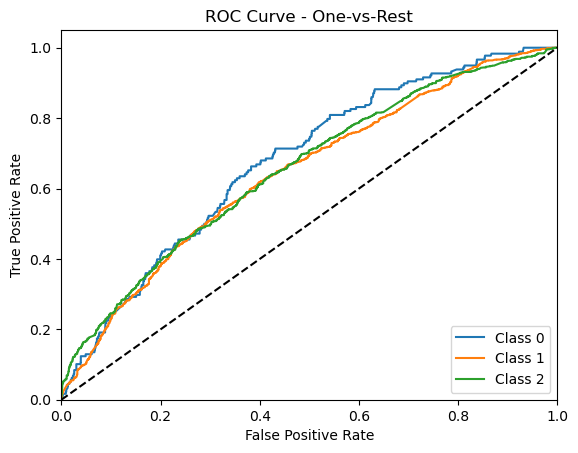

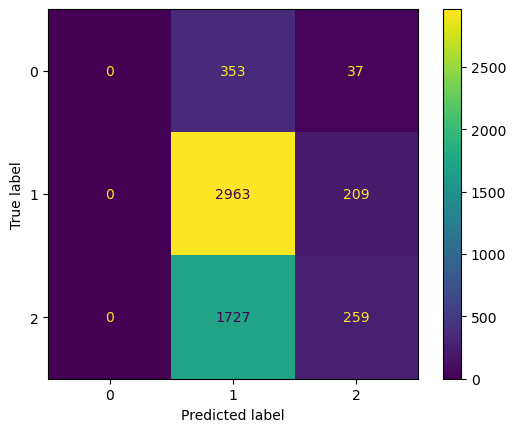

In [227]:
lrpipe_os_metrics = EvaluationMetrics(lrpipe_os, X_train, X_test, y_train, y_test)

# Print the evaluation metrics
train_results, test_results = lrpipe_os_metrics.print_scores()
print("Training Set Metrics:")
for metric, score in train_results.items():
    print(f"{metric}: {score}")   
print("\nTest set results:")
for metric, value in test_results.items():
    print(f"{metric}: {value}")
print("\ncv set results:")
mean_accuracy, std_accuracy = lrpipe_os_metrics.cross_validation(cv=5)
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)
# Plot the ROC curve
lrpipe_os_metrics.plot_roc_curve_ovr()

#Plot MAtrix Confusion
y_t_pred = lrpipe_os_metrics.pipe.predict(X_train)
lrpipe_os_metrics.plot_confusion_matrix(y_train, y_train_pred)

In [ ]:
#results

In [228]:
from imblearn.over_sampling import SMOTE


# Create an instance of SMOTE
smote = SMOTE()

# Define the pipeline
lrpipe_sm = make_pipeline(
    TfidfVectorizer(ngram_range=(1, 2)),
    smote,
    LogisticRegression(random_state=42)
)

# Fit the pipeline to the training data
lrpipe_sm.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(ngram_range=(1, 2))),
                ('smote', SMOTE()),
                ('logisticregression', LogisticRegression(random_state=42))])

Training Set Metrics:
accuracy: 0.9187094448449892
recall: 0.9187094448449892
precision: 0.9208413508342324
f1_score: 0.9189695943970747

Test set results:
accuracy: 0.6458104646908159
recall: 0.6458104646908159
precision: 0.6522055363861456
f1_score: 0.6478795176828096

cv set results:
Mean Accuracy: 0.6418578542473944
Standard Deviation of Accuracy: 0.015523547882689843


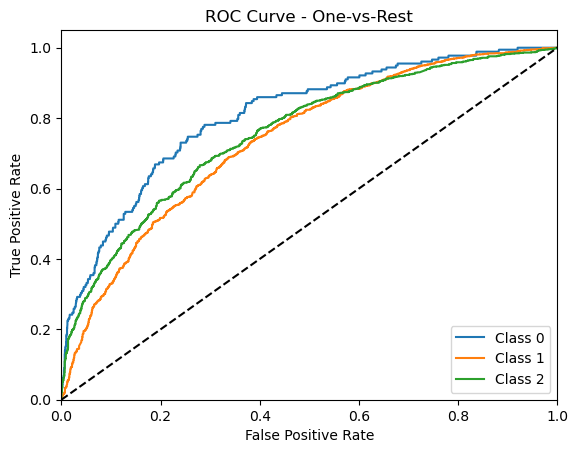

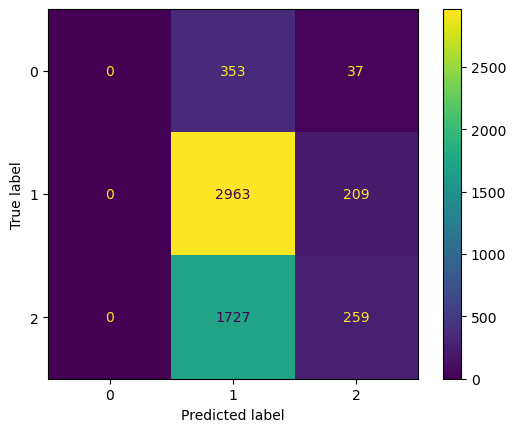

In [229]:
lrpipe_sm_metrics = EvaluationMetrics(lrpipe_sm, X_train, X_test, y_train, y_test)

# Print the evaluation metrics
train_results, test_results = lrpipe_sm_metrics.print_scores()
print("Training Set Metrics:")
for metric, score in train_results.items():
    print(f"{metric}: {score}")   
print("\nTest set results:")
for metric, value in test_results.items():
    print(f"{metric}: {value}")
print("\ncv set results:")
mean_accuracy, std_accuracy = lrpipe_sm_metrics.cross_validation(cv=5)
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)
# Plot the ROC curve
lrpipe_sm_metrics.plot_roc_curve_ovr()

#Plot MAtrix Confusion
y_t_pred = lrpipe_sm_metrics.pipe.predict(X_train)
lrpipe_sm_metrics.plot_confusion_matrix(y_train, y_train_pred)

In [ ]:
#results

# MultinomialNB

In [ ]:
mnbpipe = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1, 2))),
    ('mnb', MultinomialNB())
])

# Fit the pipeline to the training data
mnbpipe.fit(X_train, y_train)

Training Set Metrics:
accuracy: 0.8116438356164384
recall: 0.8116438356164384
precision: 0.840626599050934
f1_score: 0.7822819946071794

Test set results:
accuracy: 0.6878887669227954
recall: 0.6878887669227954
precision: 0.7334624003960132
f1_score: 0.6371899135354757

cv set results:
Mean Accuracy: 0.6265316533846741
Standard Deviation of Accuracy: 0.008132244284116703


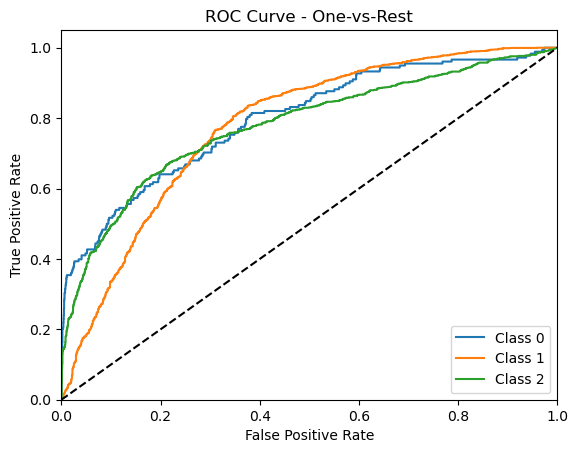

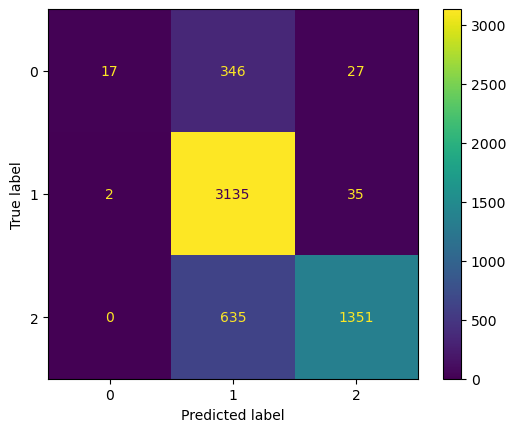

In [230]:
mnbpipe_metrics = EvaluationMetrics(mnbpipe, X_train, X_test, y_train, y_test)

# Print the evaluation metrics
train_results, test_results = mnbpipe_metrics.print_scores()
print("Training Set Metrics:")
for metric, score in train_results.items():
    print(f"{metric}: {score}")   
print("\nTest set results:")
for metric, value in test_results.items():
    print(f"{metric}: {value}")
print("\ncv set results:")
mean_accuracy, std_accuracy = mnbpipe_metrics.cross_validation(cv=5)
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)
# Plot the ROC curve
mnbpipe_metrics.plot_roc_curve_ovr()

#Plot MAtrix Confusion
y_train_pred = mnbpipe_metrics.pipe.predict(X_train)
mnbpipe_metrics.plot_confusion_matrix(y_train, y_train_pred)

In [ ]:
# MultinomialNB with Countvector

In [231]:
mnbpipe_cv = Pipeline([
    ('vect', CountVectorizer()),
    ('mnb', MultinomialNB())
])

# Fit the pipeline to the training data
mnbpipe_cv.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('mnb', MultinomialNB())])

Training Set Metrics:
accuracy: 0.8114635904830569
recall: 0.8114635904830569
precision: 0.8132041310499123
f1_score: 0.806247700580921

Test set results:
accuracy: 0.6586169045005489
recall: 0.6586169045005489
precision: 0.6458891933290482
f1_score: 0.6457279125460623

cv set results:
Mean Accuracy: 0.6427564805563002
Standard Deviation of Accuracy: 0.0059353262123448035


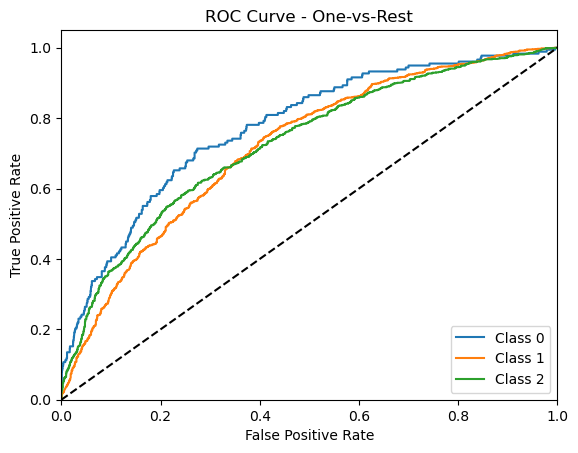

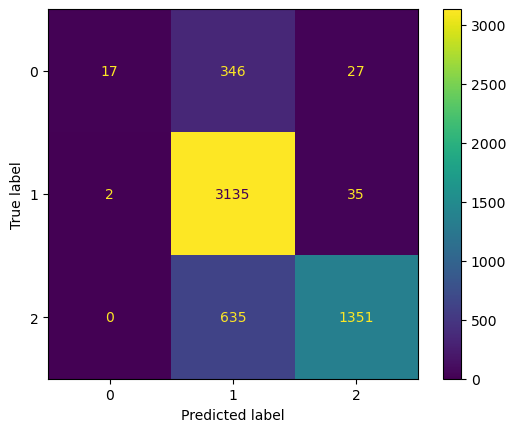

In [232]:
mnbpipe_cv_metrics = EvaluationMetrics(mnbpipe_cv, X_train, X_test, y_train, y_test)

# Print the evaluation metrics
train_results, test_results = mnbpipe_cv_metrics.print_scores()
print("Training Set Metrics:")
for metric, score in train_results.items():
    print(f"{metric}: {score}")   
print("\nTest set results:")
for metric, value in test_results.items():
    print(f"{metric}: {value}")
print("\ncv set results:")
mean_accuracy, std_accuracy = mnbpipe_cv_metrics.cross_validation(cv=5)
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)
# Plot the ROC curve
mnbpipe_cv_metrics.plot_roc_curve_ovr()

#Plot MAtrix Confusion
y_train_pred = mnbpipe_metrics.pipe.predict(X_train)
mnbpipe_metrics.plot_confusion_matrix(y_train, y_train_pred)

# Smote Balanced MultinomialNB

In [233]:
# Define the pipeline
mnbpipe_sm = make_pipeline(
    TfidfVectorizer(ngram_range=(1, 2)),
    smote,
    MultinomialNB()
)

# Fit the pipeline to the training data
mnbpipe_sm.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(ngram_range=(1, 2))),
                ('smote', SMOTE()), ('multinomialnb', MultinomialNB())])

Training Set Metrics:
accuracy: 0.8873467916366258
recall: 0.8873467916366258
precision: 0.8976011874734263
f1_score: 0.8889324796267418

Test set results:
accuracy: 0.593121112330772
recall: 0.593121112330772
precision: 0.6437337273101543
f1_score: 0.6067723347696493

cv set results:
Mean Accuracy: 0.5921078156605659
Standard Deviation of Accuracy: 0.01794774150224967


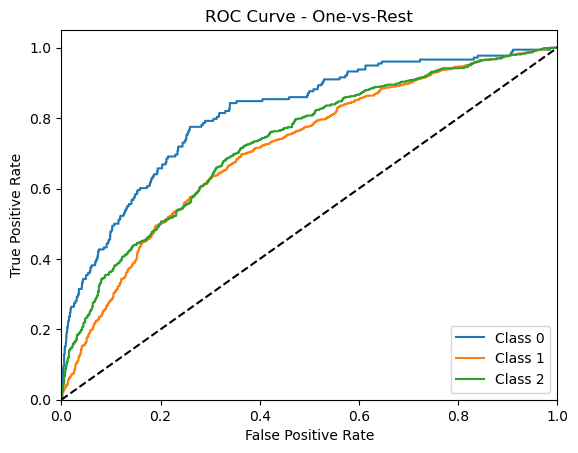

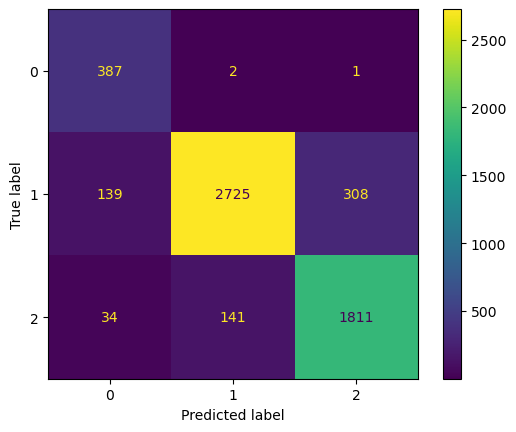

In [234]:
mnbpipe_sm_metrics = EvaluationMetrics(mnbpipe_sm, X_train, X_test, y_train, y_test)

# Print the evaluation metrics
train_results, test_results = mnbpipe_sm_metrics.print_scores()
print("Training Set Metrics:")
for metric, score in train_results.items():
    print(f"{metric}: {score}")   
print("\nTest set results:")
for metric, value in test_results.items():
    print(f"{metric}: {value}")
print("\ncv set results:")
mean_accuracy, std_accuracy = mnbpipe_sm_metrics.cross_validation(cv=5)
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)
# Plot the ROC curve
mnbpipe_sm_metrics.plot_roc_curve_ovr()

#Plot MAtrix Confusion
y_train_pred = mnbpipe_sm_metrics.pipe.predict(X_train)
mnbpipe_sm_metrics.plot_confusion_matrix(y_train, y_train_pred)

# Random Forest
>- Initial try with no parameters was overfit with training at 95% and test accuracy at 0.66

In [237]:
rfpipe = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1, 2))),
    ('rf', RandomForestClassifier(criterion = 'entropy'))
])

# Fit the pipeline to the training data
rfpipe.fit(X_train, y_train)

Pipeline(steps=[('vect', TfidfVectorizer(ngram_range=(1, 2))),
                ('rf', RandomForestClassifier(criterion='entropy'))])

Training Set Metrics:
accuracy: 0.5771449170872387
recall: 0.5771449170872387
precision: 0.6754569145509975
f1_score: 0.42835061716930883

Test set results:
accuracy: 0.5920234174899378
recall: 0.5920234174899378
precision: 0.6507176641590885
f1_score: 0.44309774432089255

cv set results:
Mean Accuracy: 0.5776860900575959
Standard Deviation of Accuracy: 0.002813068684240009


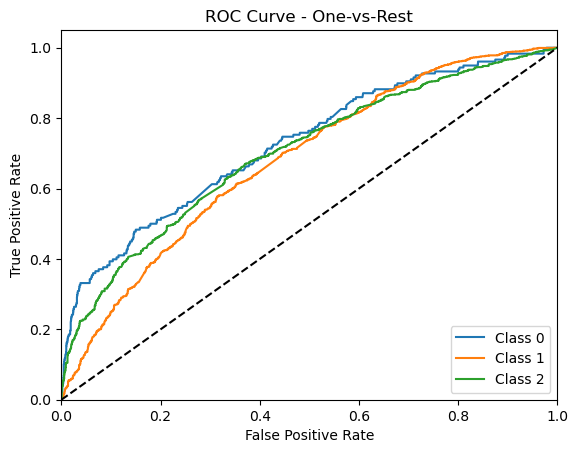

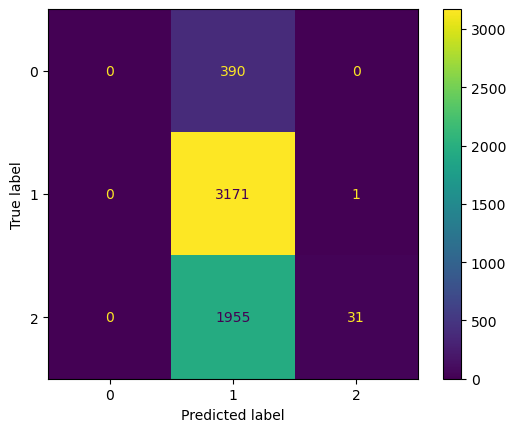

In [236]:
rfpipe_metrics = EvaluationMetrics(rfpipe, X_train, X_test, y_train, y_test)

# Print the evaluation metrics
train_results, test_results = rfpipe_metrics.print_scores()
print("Training Set Metrics:")
for metric, score in train_results.items():
    print(f"{metric}: {score}")   
print("\nTest set results:")
for metric, value in test_results.items():
    print(f"{metric}: {value}")
print("\ncv set results:")
mean_accuracy, std_accuracy = rfpipe_metrics.cross_validation(cv=5)
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)
# Plot the ROC curve
rfpipe_metrics.plot_roc_curve_ovr()

#Plot MAtrix Confusion
y_train_pred = rfpipe_metrics.pipe.predict(X_train)
rfpipe_metrics.plot_confusion_matrix(y_train, y_train_pred)

# Bagging

In [ ]:
# Best ParametersMNB:  {'mnbalpha': 2.0, 'mnbfit_prior': True, 'vectanalyzer': 'word', 'vectmax_df': 0.75, 
#                    'vectmax_features': 500, 'vectmin_df': 0.01, 'vect__ngram_range': (1, 1)}
# Best ParametersRF: {'vect_ngram_range': (1, 2), 'vect_min_df': 0.01, 'vect_max_features': 2000, 'vect_ _max_df': 0.75, 
#                     'vect_analyzer': 'word', 'rf_M_estimators': 300, "rf_min _samples_split ?2, 
# 'rf_min_samples_Teaf: 1, 'rf_max_features'? 'sart', 'rf_max depth': 20, 'rf_bo otstrap': False}

In [1]:
# Create an instance of TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=0.01, max_df=0.75, analyzer='word', max_features=1200 )

# Define the individual classifiers
lg = LogisticRegression(max_iter=1000, random_state=42)
mnb = MultinomialNB(alpha=2.0, fit_prior=True)
rf = RandomForestClassifier(n_estimators=300,min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=20, bootstrap=False )

# Define the voting classifier
vc = VotingClassifier(
    estimators=[
        ('logreg', lg),
        ('mnb', mnb),
        ('rf', rf)
    ],
    voting='soft'
)

# Create the pipeline
vc_pipeline = make_pipeline(vectorizer, vc)

# Fit the pipeline to the training data
vc_pipeline.fit(X_train, y_train)

NameError: name 'TfidfVectorizer' is not defined

In [ ]:
vc_metrics = EvaluationMetrics(vc_pipeline, X_train, X_test, y_train, y_test)

# Print the evaluation metrics
train_results, test_results = vc_metrics.print_scores()
print("Training Set Metrics:")
for metric, score in train_results.items():
    print(f"{metric}: {score}")   
print("\nTest set results:")
for metric, value in test_results.items():
    print(f"{metric}: {value}")
print("\ncv set results:")
mean_accuracy, std_accuracy = vc_metrics.cross_validation(cv=5)
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)
# Plot the ROC curve
rfpipe_metrics.plot_roc_curve_ovr()

#Plot MAtrix Confusion
y_train_pred = vc_metrics.pipe.predict(X_train)
vc_metrics.plot_confusion_matrix(y_train, y_train_pred)

# XGBoost

In [ ]:
# !pip install xgboost

In [ ]:
from xgboost import XGBClassifier

# Create an instance of TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2))

# Define the individual classifiers
lg = LogisticRegression(max_iter=1000, random_state=42)
mnb = MultinomialNB()
xgb = XGBClassifier(
    estimators=[
        ('logreg', lg),
        ('mnb', mnb),
        ('rf', rf)
    ],
    voting='soft'
)

# Create the pipeline with XGBoost instead of VotingClassifier
xgb_pipeline = make_pipeline(vectorizer, xgb)

# Fit the pipeline to the training data
xgb_pipeline.fit(X_train, y_train)

In [ ]:
xgb_metrics = EvaluationMetrics(xgb_pipeline, X_train, X_test, y_train, y_test)

# Print the evaluation metrics
train_results, test_results = xgb_metrics.print_scores()
print("Training Set Metrics:")
for metric, score in train_results.items():
    print(f"{metric}: {score}")   
print("\nTest set results:")
for metric, value in test_results.items():
    print(f"{metric}: {value}")
print("\ncv set results:")
mean_accuracy, std_accuracy = xgb_metrics.cross_validation(cv=5)
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)

# Grid Search

In [ ]:
parameters_rf = { 
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'vect__max_df': [0.5, 0.75, 1.0],
    'vect__min_df': [0.01, 0.05, 0.1],
    'vect__max_features': [500, 1000, 1500, 2000],
    'vect__analyzer': ['word', 'char', 'char_wb'],
    'rf__n_estimators': [100,300,500, 700, 900],
    'rf__max_depth': [None, 10, 30, 50, 70, 90],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['auto', 'sqrt'],
    'rf__bootstrap': [True, False]
}

In [ ]:
#Perform grid search
grid_search_rf = GridSearchCV(rfpipe, parameters, n_iter=10, cv=5, scoring='accuracy', random_state=42)
grid_search_rf.fit(X_train, y_train)

In [ ]:
#Print the best parameters and score
print("Best Parameters: ", grid_search_rf.best_params_)
print("Best Score: ", grid_search_rf.best_score_)

In [ ]:
grid_rf_metrics = EvaluationMetrics(grid_search_rf, X_train, X_test, y_train, y_test)

# Print the evaluation metrics
grid_rf_results, test_results = grid_rf_metrics.print_scores()
print("Training Set Metrics:")
for metric, score in train_results.items():
    print(f"{metric}: {score}")   
print("\nTest set results:")
for metric, value in test_results.items():
    print(f"{metric}: {value}")
print("\ncv set results:")
mean_accuracy, std_accuracy = grid_rf_metrics.cross_validation(cv=5)
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)
# Plot the ROC curve
grid_rf_metrics.plot_roc_curve_ovr()

#Plot MAtrix Confusion
y_train_pred = grid_rf_metrics.pipe.predict(X_train)
grid_rf_metrics.plot_confusion_matrix(y_train, y_train_pred)

In [ ]:
# Specify hyperparameters and their distributions
# parameters = { 
#     'vect__ngram_range': [(1,1), (1,2), (2,2)],
#     'vect__max_df': [0.5, 0.75, 1.0],
#     'vect__min_df': [0.01, 0.05, 0.1],
#     'vect__max_features': [500, 1000, 1500, 2000],
#     'vect__analyzer': ['word', 'char', 'char_wb'],
#     'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
#     'logreg__max_iter': [250, 750, 1000, 1500],
#     'logreg__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky'],
#     'logreg__penalty': ['l1', 'l2'],
#     'logreg__class_weight': ['balanced'],
#     'logreg__multi_class': [None, 'ovr', 'multinomial']
# }

In [ ]:
# Instantiate GridSearchCV object using the lrpipe pipeline
# grid_search_lr = GridSearchCV(lrpipe, parameters, cv=5, n_jobs=-1)

# # Fit on data
# grid_search_lr.fit(X_train, y_train)

In [ ]:
# eval_metrics = EvaluationMetrics(random_search, X_train, X_test, y_train, y_test)

# # Print the evaluation metrics
# train_results, test_results = eval_metrics.print_scores()
# print("Training Set Metrics:")
# for metric, score in train_results.items():
#     print(f"{metric}: {score}")   
# print("\nTest set results:")
# for metric, value in test_results.items():
#     print(f"{metric}: {value}")
# print("\ncv set results:")
# mean_accuracy, std_accuracy = eval_metrics.cross_validation(cv=5)
# print("Mean Accuracy:", mean_accuracy)
# print("Standard Deviation of Accuracy:", std_accuracy)
# # Plot the ROC curve
# eval_metrics.plot_roc_curve_ovr()

# #Plot MAtrix Confusion
# y_train_pred = eval_metrics.pipe.predict(X_train)
# eval_metrics.plot_confusion_matrix(y_train, y_train_pred)

In [ ]:
# filename = 'gridsearch_model.sav'
# joblib.dump(gridsearch_search, filename)

In [ ]:
# Gridsearch/randomsearch MNB (Deniz)

In [ ]:
# parameters_mnb = { 
#     'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
#     'vect__max_df': [0.5, 0.75, 1.0],
#     'vect__min_df': [0.01, 0.05, 0.1],
#     'vect__max_features': [500, 1000, 1500, 2000],
#     'vect__analyzer': ['word', 'char', 'char_wb'],
#     'mnb__alpha': [0.1, 0.5, 1.0, 2.0],
#     'mnb__fit_prior': [True, False]
# }

In [ ]:
# Instantiate GridSearchCV object using the lrpipe pipeline
# grid_search_mnb = GridSearchCV(mnbpipe_cv, parameters_mnb, cv=5, n_jobs=-1)

# # Fit on data
# grid_search_mnb.fit(X_train, y_train)

In [ ]:
# Gridsearch/randomsearch Randomforest

# Embedding

In [ ]:
#How to pull a specific predictor out

In [ ]:
# import tensorflow as tf
# from sklearn.linear_model import LogisticRegression

# # Define the vocabulary size and embedding dimensions
# vocab_size = 10000
# embedding_dim = 200

# # Create the embedding layer
# embedding_layer = tf.keras.layers.Embedding(vocab_size, embedding_dim)

# # Define your logistic regression model
# logreg_model = LogisticRegression()

# # Train your embedding layer on your text data
# # (Assuming you have preprocessed and tokenized your text data)
# X_train_embedded = embedding_layer(X_train)

# # Flatten the embedded data if needed
# X_train_embedded_flat = tf.keras.layers.Flatten()(X_train_embedded)

# # Fit the logistic regression model on the embedded data
# logreg_model.fit(X_train_embedded_flat, y_train)

# # Apply the same embedding layer and logistic regression model on test data
# X_test_embedded = embedding_layer(X_test)
# X_test_embedded_flat = tf.keras.layers.Flatten()(X_test_embedded)
# y_pred = logreg_model.predict(X_test_embedded_flat)

In [ ]:
# from gensim.models import Word2Vec

# # Preprocess and tokenize your text data
# # Assuming you have a list of sentences called 'sentences'

# # Train Word2Vec model
# model = Word2Vec(data['text_with_product'], size=100, window=5, min_count=20, workers=4)

# # Get the vocabulary size and embedding dimensions
# vocab_size = len(model.wv.vocab)
# embedding_dim = model.vector_size

# # Create an embedding matrix
# embedding_matrix = model.wv.vectors

# # Define your logistic regression model
# logreg_model = LogisticRegression()

# # Train your logistic regression model on the embedded data
# logreg_model.fit(embedding_matrix, y_train)

# # Apply the same embedding and logistic regression model on test data
# X_test_embedded = [model.wv[word] for word in X_test]
# y_pred = logreg_model.predict(X_test_embedded)